In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
# from NF_utils import Latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, create_latent_data
from NF_utils import Latent_data, transform,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, create_latent_data

Using device cuda:0


In [3]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [4]:
training_data_DATA = create_latent_data(DATAdataset, extractor,num_samples = 100)
training_data_MC = create_latent_data(MCdataset, extractor,num_samples = 100)

testing_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test",num_samples = 100)
testing_data_MC = create_latent_data(MCdataset, extractor, mode = "test",num_samples = 100)
val_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test",num_samples = 100)
val_data_MC = create_latent_data(MCdataset, extractor, mode = "test",num_samples = 100)

No mode given, defaulting to training



/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


No mode given, defaulting to training



In [47]:
def train(in_data, model, val = False,val_data = Latent_data(torch.empty(10000,71), torch.empty(10000,71)), num_epochs = 1, compact_num = 20):
    # train the MC model
    if(val):
        val_data.set_batch_size(int(np.floor(val_data.num_events / in_data.max_iter)))
        val_loss_hist = np.array([])
        full_val_loss_hist = np.array([])
    model.train()
    loss_hist = np.array([])
    full_loss_hist = np.array([])
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
    for i in range(num_epochs):
        with tqdm(total=in_data.max_iter, position=0, leave=True) as pbar:
            for it in tqdm(range(in_data.max_iter), position = 0, leave=True):
                optimizer.zero_grad()
                #randomly sample the latent space
                samples = in_data.sample(iteration = it)
                samples = samples.to(device)
                loss = model.forward_kld(samples)
                # Do backprop and optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                # Log loss
                if~(torch.isnan(loss)):
                    full_loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
                    if(loss < 1000):
                        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
                if(val):
                    val_samples = val_data.sample(iteration = it)
                    val_samples = val_samples.to(device)
                    val_loss = model.forward_kld(val_samples)
                    if~(torch.isnan(val_loss)):
                        full_val_loss_hist = np.append(val_loss_hist, val_loss.to('cpu').data.numpy())
                        if(val_loss < 1000):
                            val_loss_hist = np.append(val_loss_hist, val_loss.to('cpu').data.numpy())
    running_ttl = 0
    compact_hist = np.array([])
    j = 0
    for i in range(loss_hist.size):
        if(j != (i // compact_num)):
            compact_hist = np.append(compact_hist,running_ttl / compact_num)
            running_ttl = 0
        j = i // compact_num
        running_ttl += loss_hist[i]
    if(val):
        running_ttl_val = 0
        compact_hist_val = np.array([])
        j = 0
        for i in range(val_loss_hist.size):
            if(j != (i // compact_num)):
                compact_hist_val = np.append(compact_hist_val,running_ttl_val / compact_num)
                running_ttl_val = 0
            j = i // compact_num
            running_ttl_val += val_loss_hist[i]
        return compact_hist, compact_hist_val, full_loss_hist, full_val_loss_hist
    else:
        return compact_hist, loss_hist

In [48]:
def get_masked_affine(num_layers = 32):
    #mask
    b = torch.ones(71)
    for i in range(b.size()[0]):
        if i % 2 == 0:
            b[i] = 0
    masked_affine_flows = []
    for i in range(num_layers):
        s = nf.nets.MLP([71, 142, 142, 71])
        t = nf.nets.MLP([71, 142, 142, 71])
        if i % 2 == 0:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    return masked_affine_flows

In [49]:
# SETTING UP DATA MODEL

masked_affine_flows_train_DATA = get_masked_affine(52)
distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
DATA_model = masked_affine_model_DATA.to(device)

# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine(52)
distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

  0%|          | 0/1120 [02:27<?, ?it/s]


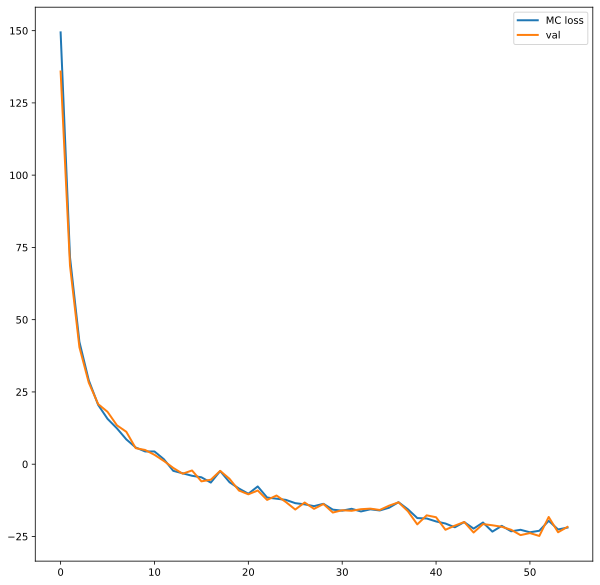

Lowest Loss: -23.558400249481203


In [50]:
# TRAINING MC
loss_hist, val_hist, full_loss_hist, full_val_hist = train(training_data_MC, MC_model, val = True, val_data = val_data_MC, num_epochs = 1)
plot_loss(loss_hist, label = "MC loss", plot_val = True, val_loss_hist = val_hist)

  0%|          | 0/1120 [01:07<?, ?it/s]


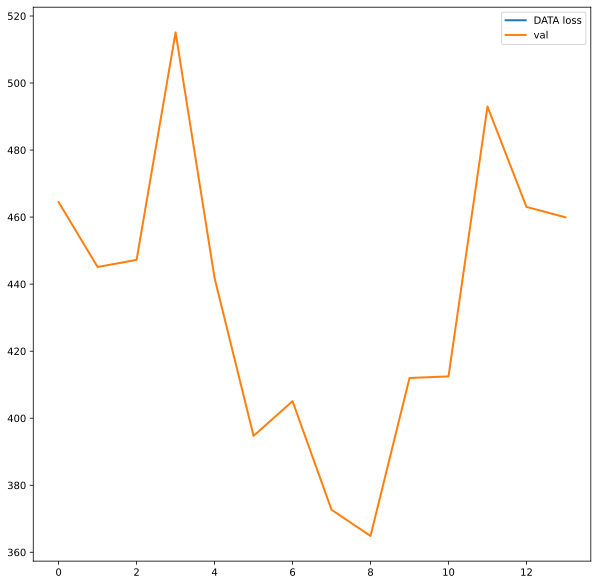

ValueError: zero-size array to reduction operation minimum which has no identity

In [51]:
# TRAINING DATA
loss_hist, val_hist, full_loss_hist, full_val_hist = train(training_data_DATA, DATA_model, val = True, val_data = val_data_DATA)
plot_loss(loss_hist, label = "DATA loss", plot_val = True, val_loss_hist = val_hist)

In [ ]:
# Testing MC
test(testing_data_MC, MC_model, data_type = "MC")
# Testing DATA
test(testing_data_DATA, DATA_model, data_type = "DATA")

In [ ]:
transformed_latent_MC = transform(testing_data_MC, MC_model)
transformed_latent_DATA = transform(testing_data_DATA, DATA_model)

In [ ]:
transformed_latent_train_MC = transform(training_data_MC, MC_model)
transformed_latent_train_DATA = transform(training_data_DATA, DATA_model)
transformed_latent_val_MC = transform(val_data_MC, MC_model)
transformed_latent_val_DATA = transform(val_data_DATA, DATA_model)

In [ ]:
# From above plotting: <transformed_latent_DATA> is the tensor with normalized DATA
# Now need to transform it back to MC version of latent space
transformed_latent_DATA_obj = Latent_data(transformed_latent_DATA,testing_data_DATA.labels)
transformed_latent_DATA_obj.set_batch_size(100)
transformed_latent_MC_obj = Latent_data(transformed_latent_MC,testing_data_MC.labels)
transformed_latent_MC_obj.set_batch_size(100)

In [ ]:
transformed_latent_train_DATA_obj = Latent_data(transformed_latent_train_DATA,training_data_DATA.labels)
transformed_latent_train_DATA_obj.set_batch_size(100)
transformed_latent_train_MC_obj = Latent_data(transformed_latent_train_MC,training_data_MC.labels)
transformed_latent_train_MC_obj.set_batch_size(100)

In [ ]:
transformed_latent_val_DATA_obj = Latent_data(transformed_latent_val_DATA,val_data_DATA.labels)
transformed_latent_val_MC_obj = Latent_data(transformed_latent_val_MC,val_data_MC.labels)

## Prediction

In [ ]:
class NFClassifier(nn.Module):
    """
    Classifier for normalized tensors
    """
    def __init__(self, input_size=71, num_classes=2, hidden_dim = 256, num_layers = 5):
        super(NFClassifier, self).__init__()
        self.layer = nn.Sequential()
        for i in range(num_layers):
            if(i == 0):
                self.layer.append(
                nn.Linear(input_size, hidden_dim)
                )
                self.layer.append(
                    nn.ReLU(inplace=True)
                )
            elif(i == num_layers - 1):
                self.layer.append(
                nn.Linear(hidden_dim, num_classes)
                )
            else:
                self.layer.append(
                    nn.Linear(hidden_dim, hidden_dim)
                )
                self.layer.append(
                    nn.ReLU(inplace=True)
                )
        self.name = "Classifier"
        
    def forward(self, h):
        c = self.layer(h)
        return c
    
    # @property
    def name(self):
        """
        Name of model.
        """
        return self.name

In [ ]:
classifier = NFClassifier().to(device)

In [ ]:
num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-5)
loss_hist = np.array([])
transformed_latent_val_MC_obj.set_batch_size(int(np.floor(transformed_latent_val_MC_obj.num_events / num_epochs)))
val_loss_hist = np.array([])
for i in range(num_epochs):
    epoch_hist = np.array([])
    with tqdm(total=transformed_latent_train_MC_obj.max_iter, position=0, leave=True) as pbar:
        for it in tqdm(range(transformed_latent_train_MC_obj.max_iter), position = 0, leave=True):
            optimizer.zero_grad()
            #randomly sample the latent space
            samples, labels = transformed_latent_train_MC_obj.sample(iteration = it, _give_labels = True)
            samples = samples.to(device)
            labels = (labels.type(torch.LongTensor)).to(device)
            # forward + backward + optimize
            outputs = classifier(samples)
            loss = criterion(outputs, labels[:,0])
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
            # Log loss
            if~(torch.isnan(loss)):
                epoch_hist= np.append(epoch_hist, loss.to('cpu').data.numpy())
    #validation
    val_samples, val_labels = transformed_latent_val_MC_obj.sample(iteration = i, _give_labels = True)
    val_samples = val_samples.to(device)
    val_labels = (val_labels.type(torch.LongTensor)).to(device)
    val_outputs = classifier(val_samples)
    val_loss = criterion(val_outputs, val_labels[:,0])
    val_loss_hist = np.append(val_loss_hist, val_loss.to('cpu').data.numpy())
    loss_hist = np.append(loss_hist, epoch_hist.mean())
print('Finished Training')

In [ ]:
plot_loss(loss_hist, plot_val =True, val_loss_hist = val_loss_hist)

In [ ]:
outputs = torch.empty(transformed_latent_MC_obj.num_events,2)

In [ ]:
#Testing
with tqdm(total=transformed_latent_MC_obj.max_iter, position=0, leave=True) as pbar:
    for it in tqdm(range(transformed_latent_MC_obj.max_iter), position = 0, leave=True):
        #randomly sample the latent space
        samples, labels = transformed_latent_MC_obj.sample(iteration = it, _give_labels = True)
        samples = samples.to(device)
        # forward + backward + optimize
        output_batch = classifier(samples)
        for i in range(transformed_latent_MC_obj.batch_size):
            outputs[it*transformed_latent_MC_obj.batch_size + i] = output_batch[i]
print('Finished Running')

In [ ]:
test_Y     = transformed_latent_MC_obj.labels.clone().detach().float().view(-1, 1).to("cpu")

In [ ]:
probs_Y = torch.softmax(outputs, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1,1)
test_acc = (test_Y == argmax_Y.float()).sum().item() / len(test_Y)
    

In [ ]:
test_acc * 100

## Testing Classifier on DATA

In [ ]:
norm_data = transformed_latent_train_DATA_obj
outputs_data = torch.empty(norm_data.num_events,2)

#Converting normalized DATA to classifier output
with tqdm(total=norm_data.max_iter, position=0, leave=True) as pbar:
    for it in tqdm(range(norm_data.max_iter), position = 0, leave=True):
        #randomly sample the latent space
        samples, labels = norm_data.sample(iteration = it, _give_labels = True)
        samples = samples.to(device)
        # forward + backward + optimize
        output_batch = classifier(samples)
        for i in range(norm_data.batch_size):
            outputs_data[it*norm_data.batch_size + i] = output_batch[i]
print('Finished Running')

In [ ]:
probs_data = torch.softmax(outputs_data, 1)
argmax_Y = torch.max(probs_data, 1)[1].view(-1,1)

In [ ]:
num_total = int(argmax_Y.size()[0])
num_signal = int(argmax_Y.sum())
signal = np.zeros(num_signal)
bg = np.zeros(num_total-num_signal)
bg_count, signal_count = 0, 0
Lambda_masses = training_data_DATA.mass
for i in range(num_total):
    if argmax_Y[i]:
        signal[signal_count] = Lambda_masses[i]
        signal_count+= 1
    else:
        bg[bg_count] = Lambda_masses[i]
        bg_count += 1

In [ ]:
histos, (h1,h2, h3) = plt.subplots(1,3, figsize = (18,4))
histos.suptitle("transformed training DATA")
h1.hist(signal, bins = 100, label = "signal", color = "b")
h2.hist(bg, bins = 100, label = "background", color = "xkcd:orange")
h3.hist(Lambda_masses, bins = 100, label = "full spectrum, train DATA")
leg = histos.legend(title = "Key")
histos.show()
histos.savefig("plots/sig_vs_bg_transformed_train_DATA.jpeg")

In [ ]:
plt.legend(title = "Key")
plt.show()

#### Checking what MC truth looks like

In [ ]:
argmax_Y = testing_data_MC.labels

In [ ]:
num_total = int(argmax_Y.size()[0])
num_signal = int(argmax_Y.sum())
signal = np.zeros(num_signal)
bg = np.zeros(num_total-num_signal)
bg_count, signal_count = 0, 0
Lambda_masses = testing_data_MC.mass
for i in range(num_total):
    if argmax_Y[i]:
        signal[signal_count] = Lambda_masses[i]
        signal_count+= 1
    else:
        bg[bg_count] = Lambda_masses[i]
        bg_count += 1

In [ ]:
histos, (h1,h2) = plt.subplots(1,2, figsize = (15,5))
h1.hist(signal, bins = 100, label = "signal", color = "b")
h2.hist(bg, bins = 100, label = "background", color = "xkcd:orange")
leg = histos.legend(title = "Key")
histos.show()